In [ ]:
#Importo il modulo drive, fornito da Colab, per interagire con Google Drive.
from google.colab import drive
#Monta il mio Google Drive nella directory locale /content/drive del runtime, con la garanzia che sia in uno stato "pulito".
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
global_var = {
    # PARAMETRI DI CARICAMENTO / PREPROCESSING DEI DATI:
    "batch_size": 64,     #Numero di campioni elaborati in un singolo batch.
    "n_workers": 2,       #Processi del DataLoader che pre-caricano i dati in parallelo.
    "max_seq_len": 1024,  #Lunghezza massima (token): i testi più lunghi verranno troncati.
                          #Quelli più corti verranno riempiti con il token <pad>.

    # PARAMETRI DEL MODELLO:
    "embedding_dim": 128,   #Dimensione dei vettori di embedding (spazio semantico dei token).
    "hidden_dim": 128,      #Neuroni del layer nascosto dell’MLP.
    "output_dim": 2,        #Dimensione dell’output: 2 classi --> 0 = Human , 1 = GenAI.

    # PARAMETRI DI TRAINING:
    "learning_rate": 1e-3,    #Tasso di apprendimento dell’ottimizzatore (es. Adam).
    "epochs": 10,             #Numero di epoche: quante volte l’intero dataset viene visto dal modello.

    # PARAMETRI DI VALIDAZIONE/REGOLARIZZAZIONE:
    "val_size": 0.2,            #Frazione di split per validazione (hold-out del 20%).
    "dropout": 0.3,             #Probabilità di spegnimento neuroni a train-time (keep probability q=0.7).
    "weight_decay": 1e-4,       #Penalità L2 per controllare l'overfitting.
    "label_smoothing": 0.05,    #Smoothing del target (per K=2: [0.95, 0.05] sul vettore obiettivo).
    "patience": 4               #Early stopping se la val-loss non migliora per 4 epoche consecutive.
}

In [ ]:
# STANDARD LIBRARY (Python):
import os                        #Gestione percorsi, variabili d'ambiente, I/O di base.
import math                      #Funzioni matematiche (p.es. ceil, log, sqrt).
import copy                      #Copie profonde/superficiali di oggetti complessi (es. pesi modello).
import re                        #Espressioni regolari per pulizia e parsing dei testi.
import random                    #RNG standard (per seed e sampling semplice).
from collections import Counter  #Conteggi frequenze di token/etichette.

# CALCOLO NUMERICO / DATI TABELLARI:
import numpy as np               #Tensori/array N-dim, operazioni numeriche vettorizzate.
import pandas as pd              #Tabelle, CSV/Parquet, join/filter/groupby.

# VISUALIZZAZIONE:
import matplotlib.pyplot as plt  #Grafici 2D (linee, barre, scatter, heatmap via imshow).
import seaborn as sns            #Wrapper statistico su Matplotlib (stile + funzioni comode).

# PROGRESS BAR (notebook-friendly):
from tqdm.notebook import tqdm   #Barra di avanzamento per loop su batch/epoche.

# PyTorch (core, dataset, mixed precision):
import torch                                              #Tensori e operazioni su CPU/GPU; gestione device.
import torch.nn as nn                                     #Moduli di rete (Linear, Dropout, ReLU, etc).
import torch.nn.functional as F                           #Funzioni funzionali (relu, cross_entropy, log_softmax, etc).
from torch.utils.data import Dataset, DataLoader, Subset  #API per dataset custom e mini-batch.
from torch.cuda import amp                                #Per AMP.
from torch.cuda.amp import autocast, GradScaler           #AMP: mixed precision e scaler.

# Scikit-learn (split + metriche):
from sklearn.model_selection import train_test_split      #Split train/val/test stratificato.
from sklearn.metrics import (
    accuracy_score,                                       #Accuratezza: (TP+TN)/totale;
    balanced_accuracy_score,                              #Media delle recall per classe;
    f1_score,                                             #F1 = 2·(precision·recall)/(precision+recall);
    precision_recall_fscore_support,                      #Precision, recall, fscore per classe e macro/micro;
    confusion_matrix,                                     #Matrice di confusione (TP/TN/FP/FN per classe);
    classification_report                                 #Report testuale riassuntivo per classe e aggregati.
)

In [ ]:
#Verifica se l'ambiente corrente ha una GPU NVIDIA disponibile (e PyTorch con build CUDA).
#Se sì, seleziona il primo device GPU ("cuda:0"); altrimenti usa il processore ("cpu").
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Log utile per debug/trasparenza: stampa il device scelto (cpu oppure cuda:0).
print(f"[LOG] Device → {device}")

[LOG] Device → cpu


In [ ]:
def collate_trim(batch):
    """
    Collate function per DataLoader.
    Input: batch = lista di tuple (x, y), con x tensore 1D di token ID (padded con 0) e y etichetta.
    Output: (xs_trim, ys) con xs_trim di shape [B, L_batch] dove L_batch = max lunghezza reale nel batch.
    Assunzione: PAD == 0 e non viene usato come token "valido".
    """
    xs, ys = zip(*batch)  #Unpack: xs = sequenze, ys = etichette; xs è una tupla di tensori 1D [T_max].

    #Lunghezza reale per sequenza: conta i token != 0 (cioè non PAD).
    lens = [int((x != 0).sum().item()) for x in xs]

    #Evita edge case L_batch = 0 se tutte le sequenze sono vuote; garantisce almeno 1.
    maxlen = max(1, max(lens)) if lens else 1

    #Taglia ogni sequenza alla lunghezza massima del batch: riduce compute/memoria.
    xs_trim = torch.stack([x[:maxlen] for x in xs])  # Shape [B, maxlen]

    #Stack delle etichette in un tensore 1D di shape [B]
    ys = torch.stack(ys)

    return xs_trim, ys

def make_loader(dataset, batch_size, shuffle):
    """
    Costruisce un DataLoader "veloce":
      - usa collate_trim per dynamic padding/trimming per-batch;
      - pin_memory su CUDA per velocizzare i transfer CPU→GPU (.to(device, non_blocking=True));
      - se n_workers > 0: worker persistenti + prefetch di più batch.
    """
    kwargs = {}
    if global_var["n_workers"] > 0:
        kwargs["persistent_workers"] = True   #Evita teardown/respawn dei worker ad ogni epoca.
        kwargs["prefetch_factor"] = 4         #Ogni worker pre-carica N batch (default=2); 4 = più aggressivo.

    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=global_var["n_workers"],
        pin_memory=(device.type == "cuda"),   #Consigliato su CUDA; innocuo su CPU.
        collate_fn=collate_trim,              #Applica il trimming dinamico definito sopra.
        **kwargs
    )

In [ ]:
PAD, UNK = "<pad>", "<unk>"                             #Token speciali: <pad> (id 0) e <unk> (id 1) riservati.
_token_re = re.compile(r"\b\w+\b", flags=re.UNICODE)    #Regex Unicode: cattura parole alfanumeriche tra confini di parola.

def basic_tokenizer(text: str):                         #Funzione di tokenizzazione minimal basata su regex.
    return _token_re.findall(text.lower())              #Lowercase + estrazione dei token; punteggiatura rimossa.

def build_vocab(text_iter, min_freq: int = 1):          #Costruisce il vocabolario da un iterabile di righe di testo.
    counter = Counter()                                 #Multinsieme di frequenze dei token.
    for line in text_iter:                              #Passata unica su tutte le righe.
        counter.update(basic_tokenizer(line))           #Aggiunge i token della riga al contatore.
    vocab = {PAD: 0, UNK: 1}                            #Inizializza il mapping con gli ID riservati.
    for tok, c in counter.most_common():                #Scorre i token per frequenza decrescente.
        if c >= min_freq:                               #Soglia minima di frequenza (filtra rumore/rari).
            vocab[tok] = len(vocab)                     #Assegna ID progressivo corrente.
    return vocab

In [ ]:
class TextDataset(Dataset):
    def __init__(self, csv_path: str, vocab: dict | None = None):  #Estende torch.utils.data.Dataset.
        df = pd.read_csv(csv_path)                                 #1) Carica il CSV in un DataFrame;
        self.texts  = df["text"].astype(str).tolist()              #2) Colonna 'text' --> lista di stringhe;
        self.labels = df["label"].astype(int).tolist()             #3) Colonna 'label' --> lista di int;
        self.vocab  = vocab or build_vocab(self.texts)             #4) Usa vocabolario passato, altrimenti ne viene costruito uno da zeo.

    def __len__(self):                                             #Obbligatorio, per la lunghezza del dataset.
        return len(self.labels)

    def encode(self, text: str):                                             #Converte stringa in tensor di ID.
        ids = [self.vocab.get(t, self.vocab[UNK])                            #1) token --> id (UNK se assente);
               for t in basic_tokenizer(text)][: global_var["max_seq_len"]]  #2) Tronca a max_seq_len;
        ids += [self.vocab[PAD]] * (global_var["max_seq_len"] - len(ids))    #3) pad fino a max_seq_len;
        return torch.tensor(ids, dtype=torch.long)                           #4) Restituisce tensor long [T].

    def __getitem__(self, idx):                                    #Obbligatorio, per l'item i-esimo.
        return self.encode(self.texts[idx]), \
               torch.tensor(self.labels[idx])

In [ ]:
def seed_everything(seed: int = 42):
    """
    Imposta tutti i generatori di numeri casuali in modo deterministico.
    Nota: torch.use_deterministic_algorithms(True) e CUBLAS_WORKSPACE_CONFIG
    rendono alcuni kernel deterministici su CUDA (può ridurre la velocità).
    """
    os.environ["PYTHONHASHSEED"] = str(seed)      # Hash di Python riproducibili (affetta set/dict order).
    # Alcuni kernel CUDA richiedono questo ENV per la piena determinism (prima dell'inizializzazione CUDA).
    os.environ.setdefault("CUBLAS_WORKSPACE_CONFIG", ":4096:8")

    random.seed(seed)                              # RNG Python stdlib
    np.random.seed(seed)                           # RNG NumPy
    torch.manual_seed(seed)                        # RNG PyTorch (CPU)
    torch.cuda.manual_seed_all(seed)               # RNG PyTorch (tutte le GPU, se presenti)

    # Modalità deterministica per cuDNN: risultati ripetibili, a scapito di ottimizzazioni.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # Dal torch 1.10+/2.x: forziamo algoritmi deterministici quando possibile.
    try:
        torch.use_deterministic_algorithms(True)
    except Exception:
        # Non tutte le build o versioni lo supportano: ignoriamo se non disponibile.
        pass

# Fissa tutti i generatori per ripetibilità.
seed_everything(42)

# -----------------------------
# PERCORSI DEI DATASET (CSV)
# -----------------------------
TRAIN_CSV = "/content/drive/MyDrive/TESI-Classificazione/MIO/dt_train_art&mh.csv"
EVAL_CSV  = "/content/drive/MyDrive/TESI-Classificazione/MIO/dt_test_art&mh.csv"   # ← VALIDATION
TEST_CSV  = "/content/drive/MyDrive/TESI-Classificazione/MIO/it_dev_full.csv"   # ← TEST

# --------------------------------------------
# 1) VOCAB costruito SOLO sul TRAIN (no leakage)
# --------------------------------------------
full_train = TextDataset(TRAIN_CSV)               # Carica train e costruisce il vocabolario internamente.
vocab = full_train.vocab                          # Mapping token→id derivato ESCLUSIVAMENTE dal train.
print(f"[LOG] Vocabulary size (from TRAIN): {len(vocab)}")

# ---------------------------------------------------------
# 2) VALIDATION su EVAL_CSV e TEST su TEST_CSV (coerenti)
#    Entrambi RIUSANO il vocabolario del TRAIN.
# ---------------------------------------------------------
eval_dataset = TextDataset(EVAL_CSV, vocab=vocab) # Validation set (per T e soglia).
test_dataset = TextDataset(TEST_CSV, vocab=vocab) # Test set finale (mai usato per scelte).

# -----------------------------------------------------------------
# 3) DATALOADER con dynamic padding (collate_trim), NO split dal train
# -----------------------------------------------------------------
# TRAIN: shuffling attivo
train_loader = make_loader(full_train,   batch_size=global_var["batch_size"], shuffle=True)

# VALIDATION: niente shuffle
val_loader   = make_loader(eval_dataset, batch_size=global_var["batch_size"], shuffle=False)

# TEST: niente shuffle
test_loader  = make_loader(test_dataset, batch_size=global_var["batch_size"], shuffle=False)

[LOG] Vocabulary size (from TRAIN): 2641


In [ ]:
print("[CHECK] EVAL rows =", len(pd.read_csv(EVAL_CSV)))
print("[CHECK] TEST rows =", len(pd.read_csv(TEST_CSV)))
print("[CHECK] len(val_dataset) =", len(eval_dataset))
print("[CHECK] len(test_dataset) =", len(test_dataset))

[CHECK] EVAL rows = 60
[CHECK] TEST rows = 1843
[CHECK] len(val_dataset) = 60
[CHECK] len(test_dataset) = 1843


In [ ]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, out_dim, p_drop=0.3):
        super().__init__()
        #Embedding lookup: mappa ID (0..vocab_size-1) in vettori R^{emb_dim}.
        #padding_idx=0 fa sì che il vettore di <pad> (id 0) sia sempre 0 e non venga aggiornato.
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)

        #Primo layer fully-connected: input 2*E (concat di mean e max), output H.
        self.fc1 = nn.Linear(emb_dim * 2, hid_dim)   #2*E per mean+max.

        self.relu = nn.ReLU()           #Non-linearità.
        self.drop = nn.Dropout(p_drop)  #Dropout con probabilità p_drop per regolarizzazione.

        #Ultimo layer: proietta da H ai K logits di classe.
        self.fc2 = nn.Linear(hid_dim, out_dim)

    def forward(self, x):
        #x: [B, T] con 0 = PAD.
        emb = self.embedding(x)                #[B, T, E] vettori per token.

        #Maschera booleana: True dove il token è reale (!=0), shape [B, T, 1] per broadcast su E.
        mask = (x != 0).unsqueeze(-1)          #[B, T, 1].

        # MEAN POOLING MASCHERATO:
        #Somma solo sui token reali e normalizza per il #token reali (clamp evita divisione per 0).
        mean = (emb * mask).sum(1) / mask.sum(1).clamp(min=1)   #[B, E].

        # MAX POOLING MASCHERATO:
        #Metti -inf dove c'è PAD così il max ignora quei posizionamenti.
        emb_masked = emb.masked_fill(~mask, float('-inf'))      #[B, T, E].
        maxp, _ = emb_masked.max(dim=1)                         #[B, E].

        #Concatena le due viste (statistiche) lungo la dimensione dei canali.
        feat = torch.cat([mean, maxp], dim=1)                   #[B, 2E].

        #Testa MLP: FC -> ReLU -> Dropout -> FC (logits)
        h = self.relu(self.fc1(feat))                           #[B, H].
        h = self.drop(h)                                        #[B, H].
        return self.fc2(h)                                      #[B, K].

# REINSTANZIA IL MODELLO (aggiorna alcuni iper-parametri globali):
global_var["hidden_dim"] = 128
global_var["dropout"] = 0.3

model = TextClassifier(
    vocab_size=len(vocab),
    emb_dim=global_var["embedding_dim"],
    hid_dim=global_var["hidden_dim"],
    out_dim=global_var["output_dim"],
    p_drop=global_var["dropout"]
).to(device)  #Sposta i parametri sul device selezionato (cuda/cpu).

In [ ]:
#Pesi di classe (se dataset sbilanciato). Calcolati sul TRAIN.
cnt = Counter(full_train.labels)                    #Conta esempi per classe sul solo TRAIN.
tot = len(full_train)                               #Numero totale esempi train.
imbalance = abs(cnt[0] - cnt[1]) / max(1, tot)

if imbalance < 0.05:
    print("[LOG] Dataset train bilanciato → niente class weights")
    loss_fn = nn.CrossEntropyLoss(label_smoothing=global_var["label_smoothing"])
else:
    print("[LOG] Dataset train sbilanciato → uso class weights")
    w = torch.tensor([tot/cnt[0], tot/cnt[1]], dtype=torch.float, device=device)
    loss_fn = nn.CrossEntropyLoss(weight=w, label_smoothing=global_var["label_smoothing"])

#Ottimizzatore Adam (L2 "coupled" via weight_decay). Per decoupled L2 usare AdamW.
optimizer = torch.optim.Adam(model.parameters(),
                             lr=global_var["learning_rate"],
                             weight_decay=global_var["weight_decay"])

#Scheduler: riduce il LR quando la val_loss "platea" (non migliora).
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2
)

def train_amp(model, train_loader, val_loader, epochs, patience=4):
    """
    Usa:
      - loss_fn, optimizer, scheduler già definiti nella cella sopra (class weights, wd, ReduceLROnPlateau)
      - AMP per velocizzare su GPU
      - dynamic padding (viene dal DataLoader)
      - early stopping con 'patience'
    """
    #GradScaler per stabilizzare fp16 (abilitato solo su CUDA). Su CPU resta disabilitato.
    scaler = torch.amp.GradScaler('cuda', enabled=(device.type=="cuda"))

    history = {"train": [], "val": []}    #Tracciamento delle loss per epoca.
    best_val = math.inf                   #Miglior val_loss osservata (per early stopping).
    best_state = None                     #Stato del modello corrispondente alla miglior val.
    bad = 0                               #Conteggio epoche senza miglioramento significativo.

    try:
        import torch as _t
        if hasattr(_t, "compile"):
            model = _t.compile(model)
    except Exception:
        pass

    for ep in range(epochs):
        # TRAIN:
        model.train()
        running = 0.0
        pbar = tqdm(train_loader, unit="batch", desc=f"Epoch {ep+1}/{epochs} [train]")
        for bx, by in pbar:
            #Trasferimento su device con copie non bloccanti (richiede pin_memory=True nel DataLoader).
            bx = bx.to(device, non_blocking=True)
            by = by.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)   #Azzeramento gradienti (set None = più efficiente).

            #Autocast: precisione mista (fp16/fp32) in forward e loss su CUDA.
            with torch.amp.autocast('cuda', enabled=(device.type=="cuda")):
                logits = model(bx)                  #Forward --> logits [B, K].
                loss = loss_fn(logits, by)          #CE (con smoothing, e pesi se attivi).

            #Backward in fp16 scalato --> unscale --> clip --> step.
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     #Clipping L2 dei gradienti.
            scaler.step(optimizer)                                      #Applica l'aggiornamento dei pesi (scalato).
            scaler.update()                                             #Aggiorna il fattore di scala per fp16.

            running += loss.item()                                      #Accumula la loss media mostrata nella barra di progresso.
            pbar.set_postfix(loss=running/(pbar.n+1))

        # VALIDATION:
        model.eval()
        val_loss = 0.0
        #Inference_mode: no grad + no autograd bookkeeping; autocast per allineare precisione.
        with torch.inference_mode(), torch.amp.autocast('cuda', enabled=(device.type=="cuda")):
            for bx, by in val_loader:
                bx = bx.to(device, non_blocking=True)
                by = by.to(device, non_blocking=True)
                val_loss += loss_fn(model(bx), by).item()
        val_loss /= max(1, len(val_loader))

        #Log e storia.
        history["train"].append(running/max(1, len(train_loader)))
        history["val"].append(val_loss)
        print(f"[LOG] Ep{ep+1}: train={history['train'][-1]:.4f} | val={val_loss:.4f}")

        #Scheduler pilotato dalla val_loss (ReduceLROnPlateau).
        scheduler.step(val_loss)

        # EARLY STOPPING:
        #Miglioramento "significativo" se supera un delta minimo (1e-4).
        if val_loss < best_val - 1e-4:
            best_val = val_loss
            best_state = copy.deepcopy(model.state_dict())    #Salva i pesi migliori.
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                print(f"[LOG] Early stop a epoca {ep+1} (best val={best_val:.4f}).")
                break

    #Ripristina i pesi migliori (se esistono) prima di restituire la storia.
    if best_state is not None:
        model.load_state_dict(best_state)
    return history

#Esecuzione del training con impostazioni globali.
history = train_amp(model, train_loader, val_loader,
                    global_var["epochs"], patience=global_var["patience"])

[LOG] Dataset train bilanciato → niente class weights


Epoch 1/10 [train]:   0%|          | 0/4 [00:00<?, ?batch/s]

W0930 21:06:38.803000 149 torch/utils/cpp_extension.py:118] [0/0] No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


[LOG] Ep1: train=0.6562 | val=0.7256


Epoch 2/10 [train]:   0%|          | 0/4 [00:00<?, ?batch/s]

[LOG] Ep2: train=0.6866 | val=0.6827


Epoch 3/10 [train]:   0%|          | 0/4 [00:00<?, ?batch/s]

[LOG] Ep3: train=0.6276 | val=0.6443


Epoch 4/10 [train]:   0%|          | 0/4 [00:00<?, ?batch/s]

[LOG] Ep4: train=0.5833 | val=0.6071


Epoch 5/10 [train]:   0%|          | 0/4 [00:00<?, ?batch/s]

[LOG] Ep5: train=0.5319 | val=0.5952


Epoch 6/10 [train]:   0%|          | 0/4 [00:00<?, ?batch/s]

[LOG] Ep6: train=0.5030 | val=0.5459


Epoch 7/10 [train]:   0%|          | 0/4 [00:00<?, ?batch/s]

[LOG] Ep7: train=0.4597 | val=0.5290


Epoch 8/10 [train]:   0%|          | 0/4 [00:00<?, ?batch/s]

[LOG] Ep8: train=0.4177 | val=0.5016


Epoch 9/10 [train]:   0%|          | 0/4 [00:00<?, ?batch/s]

[LOG] Ep9: train=0.3819 | val=0.4724


Epoch 10/10 [train]:   0%|          | 0/4 [00:00<?, ?batch/s]

[LOG] Ep10: train=0.3667 | val=0.4204


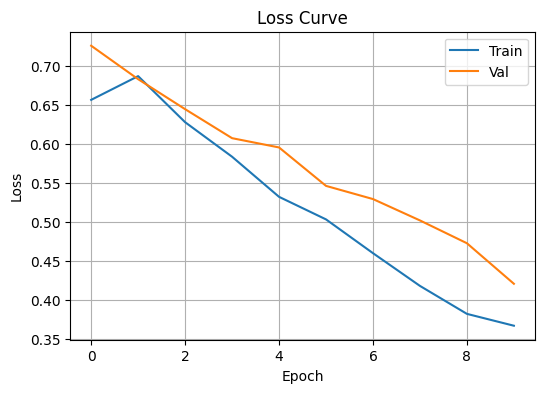

In [ ]:
plt.figure(figsize=(6,4))                                           #Crea una nuova figura 6x4 pollici.
plt.plot(history["train"], label="Train")                           #Traccia la curva della loss di training.
plt.plot(history["val"],   label="Val")                             #Traccia la curva della loss di validazione.
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss Curve")    #Etichette degli assi X (epoche) e Y (loss) e titolo del grafico.
plt.legend(); plt.grid(True); plt.show()                            #Mostra la legenda (Train/Val), aggiunge la griglia per leggere meglio i valori e renderizza il grafico nella cella.

/usr/local/lib/python3.12/dist-packages/torch/optim/lbfgs.py:457: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  loss = float(closure())


[VAL] temperatura ottima T=0.049
[VAL] soglia ottima t*=0.75 (bal_acc=1.000, f1_macro=1.000, acc=1.000)


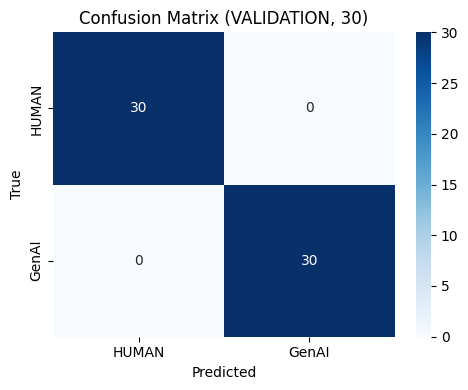


[VALIDATION] classification_report (30 righe)
              precision  recall  f1-score  support
HUMAN               1.0     1.0       1.0     30.0
GenAI               1.0     1.0       1.0     30.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0     60.0
weighted avg        1.0     1.0       1.0     60.0


In [ ]:
def evaluate_loader(model, loader, label_names=("HUMAN","GenAI"),
                    temperature=1.0, threshold=None, plot_cm=False, title_suffix=""):
    model.eval()                                           #Modalità valutazione: disabilita dropout/batchnorm.
    y_true, y_pred = [], []                                #Accumulatori: etichette vere e predette.

    with torch.inference_mode():                           #No autograd per efficienza/memoria.
        for bx, by in loader:
            #Forward con eventuale temperature scaling (T=1 --> invariato).
            logits = model(bx.to(device)) / temperature

            if threshold is None:
                #Multiclasse standard: predizione = argmax dei logits.
                pred = logits.argmax(1).cpu().numpy()
            else:
                #Binaria con soglia: usa p(classe=1) e confronta con t.
                p1 = F.softmax(logits, dim=1)[:, 1].cpu().numpy()
                pred = (p1 >= threshold).astype(int)

            #Accumula predizioni e label (su CPU/numpy).
            y_pred.extend(pred)
            y_true.extend(by.cpu().numpy())

    # REPORT DETTAGLIATO (dict) CON METRICHE PER CLASSE E MACRO/MICRO/WEIGHTED:
    report = classification_report(
        y_true, y_pred, target_names=list(label_names), output_dict=True, digits=4, labels=[0, 1] # Added labels parameter
    )

    # CONFUSION MATRIX (righe = True, colonne = Pred).
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1]) # Added labels parameter

    if plot_cm:
        #Heatmap della confusion matrix con etichette leggibili.
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=label_names, yticklabels=label_names)
        ttl = "Confusion Matrix" + (f" {title_suffix}" if title_suffix else "")
        plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(ttl)
        plt.tight_layout(); plt.show()

    return report, cm


def evaluate_csv(model, csv_path, vocab, batch_size=None, n_workers=None,
                 label_names=("HUMAN","GenAI"), temperature=1.0, threshold=None,
                 plot_cm=False, title_suffix=""):
    #Dimensione batch di default dalla config globale.
    batch_size = batch_size or global_var["batch_size"]

    #Costruisce dataset dal CSV riusando il vocabolario del training.
    ds = TextDataset(csv_path, vocab=vocab)

    #DataLoader con dynamic padding via collate_trim (make_loader gestisce n_workers/pin_memory).
    dl = make_loader(ds, batch_size=batch_size, shuffle=False)

    #Valuta come sopra (stesse opzioni di temperature/soglia/plot).
    rep, cm = evaluate_loader(
        model, dl, label_names=label_names,
        temperature=temperature, threshold=threshold,
        plot_cm=plot_cm, title_suffix=title_suffix
    )

    #Restituisce anche la dimensione del dataset per completezza.
    return rep, cm, len(ds)

# 1) CALIBRAZIONE DELLE PROBABILITA' (ottimizza la temperatura T su validation):
def calibrate_temperature(model, val_loader, device):
    model.eval()                                          #Modalità eval: disabilita dropout/batchnorm.
    logits_list, labels_list = [], []                     #Accumulatori per logits e label su tutta la VAL.
    with torch.inference_mode():                          #No grad, mem/compute più leggeri nel loop.
        for bx, by in val_loader:
            logits_list.append(model(bx.to(device)))      #Forward --> logits [B,C].
            labels_list.append(by.to(device))             #Salva etichette corrispondenti [B].
    logits = torch.cat(logits_list)                       #[N,C] tutti i logits di VAL.
    labels = torch.cat(labels_list)                       #[N]   tutte le label di VAL.

    nll = nn.CrossEntropyLoss()                                     #NLL su logits non normalizzati.
    logT = torch.tensor(0.0, device=device, requires_grad=True)     #Param: logT.
    optimizer = torch.optim.LBFGS([logT], lr=0.5, max_iter=50)      #L-BFGS per unidimensionale.

    def closure():
        optimizer.zero_grad()                             #Richiesto da L-BFGS.
        T = torch.exp(logT)                               #Temperatura positiva.
        loss = nll(logits / T, labels)                    #NLL con scaling dei logits.
        loss.backward()                                   #Gradiente rispetto a logT.
        return loss

    optimizer.step(closure)                               #Esegue le iterazioni L-BFGS.
    T = torch.exp(logT).item()                            #Estrae T scalare (float).
    print(f"[VAL] temperatura ottima T={T:.3f}")          #Log del valore trovato.
    return T

# 2) TUNING SOGLIA SU VALIDATION (usando T):
def tune_threshold_on_val(model, val_loader, device, temperature=1.0, metric="balanced_accuracy"):
    model.eval()                                                  #Eval per disattivare dropout/batchnorm.
    y_true_val, y_prob_val = [], []                               #Accumulatori: etichette e p(classe=1).
    with torch.inference_mode():
        for bx, by in val_loader:
            logits = model(bx.to(device)) / temperature             #Applica scaling di temperatura.
            p1 = F.softmax(logits, dim=1)[:, 1].cpu().numpy()       #Probabilità della classe 1.
            y_prob_val.extend(p1); y_true_val.extend(by.numpy())    #Salva per tutta la VAL.
    y_true_val = np.array(y_true_val)
    y_prob_val = np.array(y_prob_val)

    best_t, best_score = 0.5, -1.0                        #Inizializza soglia/score migliori.
    for t in np.linspace(0.05, 0.95, 19):                 #Grid search su 19 soglie in [0.05,0.95].
        y_hat = (y_prob_val >= t).astype(int)             #Predizione binaria a soglia t.

        #Scegli metrica: balanced accuracy (default), oppure macro-F1.
        score = (balanced_accuracy_score(y_true_val, y_hat)
                 if metric == "balanced_accuracy"
                 else f1_score(y_true_val, y_hat, average="macro"))
        if score > best_score:                            #Aggiorna se migliora.
            best_score, best_t = score, t

    #Report finale sulla VAL alla soglia migliore trovata.
    y_hat = (y_prob_val >= best_t).astype(int)
    print(f"[VAL] soglia ottima t*={best_t:.2f} "
          f"(bal_acc={balanced_accuracy_score(y_true_val, y_hat):.3f}, "
          f"f1_macro={f1_score(y_true_val, y_hat, average='macro'):.3f}, "
          f"acc={accuracy_score(y_true_val, y_hat):.3f})")
    return best_t

# 3) VALUTAZIONE SU TEST CON T E SOGLIA TROVATA SU VAL:
def evaluate_on_test_with_threshold(model, test_loader, device, t, temperature=1.0):
    model.eval()                                                  #Eval mode per test.
    y_true, y_prob = [], []                                       #Ground-truth e p(classe=1).
    with torch.inference_mode():
        for bx, by in test_loader:
            logits = model(bx.to(device)) / temperature           #Applica T ottima.
            p1 = F.softmax(logits, dim=1)[:, 1].cpu().numpy()
            y_prob.extend(p1); y_true.extend(by.numpy())
    y_true = np.array(y_true)
    y_pred = (np.array(y_prob) >= t).astype(int)                  #Predizione binaria con soglia t*.

    #Metriche principali.
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", pos_label=1)
    f1m = f1_score(y_true, y_pred, average="macro")
    bal = balanced_accuracy_score(y_true, y_pred)
    print(f"[VAL] acc={acc:.3f}  prec={prec:.3f}  rec={rec:.3f}  f1_bin={f1:.3f}  f1_macro={f1m:.3f}  bal_acc={bal:.3f}\n")
    print(classification_report(y_true, y_pred, digits=3))        #Report per classe e macro/micro avg.

    #Matrice di confusione e heatmap.
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cbar=False)
    plt.xlabel("Pred"); plt.ylabel("True"); plt.title(f"Confusion Matrix (test)  T={temperature:.2f}  t={t:.2f}")
    plt.tight_layout(); plt.show()

# ESECUZIONE COMPLETA:
# ====== VALIDATION (30) → Calibrazione T + tuning soglia t* ======
T = calibrate_temperature(model, val_loader, device)   # su VALIDATION (30)
t_star = tune_threshold_on_val(model, val_loader, device,
                               temperature=T, metric="balanced_accuracy")

# ====== VALIDATION (30) → Report + Confusion Matrix (VALIDATION) ======
rep_val, cm_val = evaluate_loader(
    model, val_loader,
    label_names=("HUMAN","GenAI"),
    temperature=T, threshold=t_star,
    plot_cm=True, title_suffix="(VALIDATION, 30)"
)
print("\n[VALIDATION] classification_report (30 righe)")
print(pd.DataFrame(rep_val).T[["precision","recall","f1-score","support"]])

In [ ]:
BASE = "/content/drive/MyDrive/TESI-Classificazione/MIO"        #Percorso base di lavoro su Google Drive.
os.makedirs(BASE, exist_ok=True)                                #Crea la directory se non esiste (idempotente).

#Se non è stato definito val_loader nel notebook, usa il test_loader come validation.
try:
    val_loader                                                 #Prova ad accedere al nome: se non esiste lancia NameError.
except NameError:
    val_loader = test_loader                                   #Fallback sicuro: evita crash nelle funzioni che richiedono VAL.

def extract_vocab(obj):
    """
    Restituisce obj.vocab se esiste; se obj è un Subset o un DataLoader,
    scende ricorsivamente in .dataset finché trova 'vocab'.
    """
    seen = set()                                               #Set di id() per evitare cicli (es. riferimenti ricorsivi).
    while obj is not None and id(obj) not in seen:             #Cammina finché c'è un oggetto nuovo nella catena.
        seen.add(id(obj))                                      #Marca l'oggetto corrente come visitato.
        if hasattr(obj, "vocab"):                              #Caso base: l'oggetto espone direttamente il vocabolario.
            return obj.vocab
        obj = getattr(obj, "dataset", None)                    #Altrimenti scendi in .dataset (Subset/DataLoader/...).
    return None                                                #Se non trovato, segnala fallimento.

#Prova a prendere il vocab da sorgenti note (in ordine di probabilità).
base_vocab = None
for cand in [
    globals().get("train_dataset", None),             #Può essere Subset --> ha .dataset interno.
    globals().get("full_train", None),                #Istanza completa del dataset di train.
    globals().get("train_ds", None),                  #Eventuale alias usato altrove.
    globals().get("train_loader", None),              #DataLoader: si scende in .dataset.
]:
    base_vocab = extract_vocab(cand)                  #Tenta l'estrazione ricorsiva.
    if base_vocab is not None:
        break                                         #Appena trovato, interrompi la ricerca.

#Fallback: usa 'vocab' globale se esiste.
if base_vocab is None and "vocab" in globals():
    base_vocab = vocab                                #Riutilizza il mapping già in memoria.

#Ultimo fallback: ricostruisce dal TRAIN_CSV (non ideale ma funziona)
if base_vocab is None and "TRAIN_CSV" in globals():
    print("[WARN] Non trovo il vocab del training; lo ricostruisco dal TRAIN_CSV (non ideale).")
    base_vocab = TextDataset(TRAIN_CSV).vocab         #Ricostruzione completa.

if base_vocab is None:
    raise RuntimeError(
        "Impossibile recuperare il vocabolario del training. "
        "Assicurati che 'train_dataset' (o 'train_loader') sia in memoria, "
        "oppure definisci una variabile globale 'vocab' con il mapping token→id."
    )

print(f"[LOG] Vocab recuperato correttamente (size={len(base_vocab):,}).")  #Esito positivo con dimensione formattata.

[LOG] Vocab recuperato correttamente (size=2,641).


In [ ]:
def evaluate_loader(model, loader, label_names=("HUMAN","GenAI"),
                    temperature=1.0, threshold=None, plot_cm=False, title_suffix=""):
    model.eval()                                           #Modalità valutazione: disabilita dropout/batchnorm.
    y_true, y_pred = [], []                                #Accumulatori: etichette vere e predette.

    with torch.inference_mode():                           #No autograd per efficienza/memoria.
        for bx, by in loader:
            #Forward con eventuale temperature scaling (T=1 --> invariato).
            logits = model(bx.to(device)) / temperature

            if threshold is None:
                #Multiclasse standard: predizione = argmax dei logits.
                pred = logits.argmax(1).cpu().numpy()
            else:
                #Binaria con soglia: usa p(classe=1) e confronta con t.
                p1 = F.softmax(logits, dim=1)[:, 1].cpu().numpy()
                pred = (p1 >= threshold).astype(int)

            #Accumula predizioni e label (su CPU/numpy).
            y_pred.extend(pred)
            y_true.extend(by.cpu().numpy())

    # REPORT DETTAGLIATO (dict) CON METRICHE PER CLASSE E MACRO/MICRO/WEIGHTED:
    report = classification_report(
        y_true, y_pred, target_names=list(label_names), output_dict=True, digits=4
    )

    # CONFUSION MATRIX (righe = True, colonne = Pred).
    cm = confusion_matrix(y_true, y_pred)

    if plot_cm:
        #Heatmap della confusion matrix con etichette leggibili.
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=label_names, yticklabels=label_names)
        ttl = "Confusion Matrix" + (f" {title_suffix}" if title_suffix else "")
        plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(ttl)
        plt.tight_layout(); plt.show()

    return report, cm


def evaluate_csv(model, csv_path, vocab, batch_size=None, n_workers=None,
                 label_names=("HUMAN","GenAI"), temperature=1.0, threshold=None,
                 plot_cm=False, title_suffix=""):
    #Dimensione batch di default dalla config globale.
    batch_size = batch_size or global_var["batch_size"]

    #Costruisce dataset dal CSV riusando il vocabolario del training.
    ds = TextDataset(csv_path, vocab=vocab)

    #DataLoader con dynamic padding via collate_trim (make_loader gestisce n_workers/pin_memory).
    dl = make_loader(ds, batch_size=batch_size, shuffle=False)

    #Valuta come sopra (stesse opzioni di temperature/soglia/plot).
    rep, cm = evaluate_loader(
        model, dl, label_names=label_names,
        temperature=temperature, threshold=threshold,
        plot_cm=plot_cm, title_suffix=title_suffix
    )

    #Restituisce anche la dimensione del dataset per completezza.
    return rep, cm, len(ds)

[LOG] Trovato CSV di test: /content/drive/MyDrive/TESI-Classificazione/MIO/it_dev_full.csv (1843 righe)
[LOG] Colonna 'topic' non trovata nel CSV (salto la distribuzione per topic).

[LOG] Distribuzione per label (0=HUMAN, 1=GenAI):
label
1    1843
[VAL] temperatura ottima T=0.049
[VAL] soglia ottima t*=0.75 (bal_acc=1.000, f1_macro=1.000, acc=1.000)


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


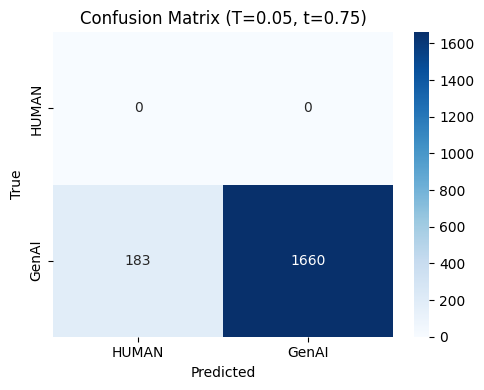


[LOG] Test su it_dev_full.csv — campioni: 1843
Accuracy: 0.9007  |  F1 macro: 0.4739  |  Precision macro: 0.5000  |  Recall macro: 0.4504


In [ ]:
TEST_CSV = f"{BASE}/it_dev_full.csv"  # ← Usa il file già presente nella cartella di lavoro.

# ----------------------------------------------------------------
# 🔎 Verifiche rapide: esistenza file + distribuzioni (solo lettura)
# ----------------------------------------------------------------
if not os.path.exists(TEST_CSV):
    raise FileNotFoundError(
        f"[ERRORE] Il file di evaluation non esiste: {TEST_CSV}. "
        "Assicurati che il percorso sia corretto."
    )

# Leggiamo il CSV solo per stampare distribuzioni (il file NON viene modificato)
df_test = pd.read_csv(TEST_CSV, encoding="utf-8")

print(f"[LOG] Trovato CSV di test: {TEST_CSV} ({len(df_test)} righe)")

# Stampa conteggi per 'topic' se presente
if "topic" in df_test.columns:
    print("[LOG] Distribuzione per topic:")
    # .to_string() mantiene un output tabellare compatto in console
    print(df_test["topic"].value_counts(dropna=False).to_string())
else:
    print("[LOG] Colonna 'topic' non trovata nel CSV (salto la distribuzione per topic).")

# Stampa conteggi per 'label' se presente
if "label" in df_test.columns:
    print("\n[LOG] Distribuzione per label (0=HUMAN, 1=GenAI):")
    # sort_index() per avere (0, 1) in ordine
    print(df_test["label"].value_counts(dropna=False).sort_index().to_string())
else:
    print("\n[LOG] Colonna 'label' non trovata nel CSV (salto la distribuzione per label).")

# ----------------------------------------------------------------
# 🔥 Calibrazione della temperatura e tuning della soglia su validation
#     - Queste funzioni devono essere già disponibili nel tuo ambiente.
#     - T_eval: temperatura che minimizza la NLL su validation.
#     - t_eval: soglia che massimizza la metrica scelta (es. balanced_accuracy).
# ----------------------------------------------------------------
T_eval = calibrate_temperature(model, val_loader, device)  # stima T su validation
t_eval = tune_threshold_on_val(
    model,
    val_loader,
    device,
    temperature=T_eval,
    metric="balanced_accuracy"  # puoi cambiare in "f1_macro" se preferisci
)

# ----------------------------------------------------------------
# 📈 Valutazione sul CSV di TEST (applica T e t* trovati)
#     - evaluate_csv legge direttamente EVAL_CSV e produce:
#         rep_amh: classification_report (dict)
#         cm_amh : confusion matrix (ndarray / DataFrame)
#         n_amh  : numero di campioni valutati
#     - plot_cm=True per disegnare la confusion matrix
# ----------------------------------------------------------------
rep_amh, cm_amh, n_amh = evaluate_csv(
    model,
    TEST_CSV,
    vocab=base_vocab,                         # riusa il vocab del training
    label_names=("HUMAN", "GenAI"),          # etichette leggibili
    temperature=T_eval,                       # temperatura calibrata
    threshold=t_eval,                         # soglia ottimizzata su validation
    plot_cm=True,
    title_suffix=f"(T={T_eval:.2f}, t={t_eval:.2f})"
)

# ----------------------------------------------------------------
# 🧾 Report compatto in console
# ----------------------------------------------------------------
print(f"\n[LOG] Test su {os.path.basename(TEST_CSV)} — campioni: {n_amh}")
print(
    f"Accuracy: {rep_amh['accuracy']:.4f}  |  "
    f"F1 macro: {rep_amh['macro avg']['f1-score']:.4f}  |  "
    f"Precision macro: {rep_amh['macro avg']['precision']:.4f}  |  "
    f"Recall macro: {rep_amh['macro avg']['recall']:.4f}"
)

Questo blocco costruisce un **tabellone di evaluation**: legge il CSV creato in precedenza, esegue **inference** con *temperature scaling* $T_{\text{eval}}$ e **soglia** $t_{\text{eval}}$, aggrega **probabilità**, **predizioni**, **etichette vere**, e produce una **tabella ordinata** (errori in alto) oltre a salvare un CSV completo su Drive.

- **Rilevamento BASE:** se la variabile non esiste, prova due path noti su Drive e prende il primo che trova.
- **Caricamento eval:** `TextDataset(EVAL_CSV, vocab=full_train.vocab)` garantisce che gli ID token siano **coerenti** con il training.
- **Inference:** per ogni batch, calcola
$$
p_{1}=\big(\mathrm{softmax}(z/T_{\text{eval}})\big)_{c=1},
\qquad
\hat y=\mathbf{1}\!\left[p_{1}\ge t_{\text{eval}}\right],
$$
  dove $p_{1}$ è la probabilità della classe *GenAI*.
- **Output tabellare:** costruisce un `DataFrame` con colonne testuali e numeriche, mappa gli ID a stringhe (*HUMAN/GenAI*), aggiunge un flag **✓/✗** e **ordina** portando in testa gli errori.
- **Visualizzazione & salvataggio:** mostra a schermo le **prime 30 righe** e salva **tutto** in un CSV versionato con $T_{\text{eval}}$ e $t_{\text{eval}}$ nel nome. Un secondo riquadro opzionale mostra **solo gli errori**.

In [ ]:
#Se BASE non è definito, si prova a rilevarlo (cartella TESI o TEST su Drive).
if 'BASE' not in locals():
    for _p in ["/content/drive/MyDrive/TESI-Classificazione/MIO",
               "/content/drive/MyDrive/TEST-Classificazione/MIO"]:
        if os.path.isdir(_p):
            BASE = _p
            break

#Si definisce il path del CSV di evaluation (creato nel blocco precedente).
TEST_CSV = f"{BASE}/it_dev_full.csv"

#Sanity check: il file deve esistere.
assert os.path.exists(TEST_CSV), f"File non trovato: {TEST_CSV}"

# 1) COSTRUZIONE DI UN DATALOADER SULL'EVAL RIUSANDO IL VOCAB DEL TRAIN (coerenza ID):
test_ds = TextDataset(TEST_CSV, vocab=full_train.vocab)
test_dl = DataLoader(
    test_ds,
    batch_size=global_var["batch_size"],
    num_workers=min(2, global_var["n_workers"]),        #Limita i worker (eval è leggera)
    shuffle=False,
    pin_memory=(device.type=="cuda")                    #Transfer H→D più rapido su CUDA
)

# 2) INFERENCE: CALCOLA prob(GenAI) E pred BINARIA CON SOGLIA t_eval.
probs, preds = [], []
model.eval()
with torch.inference_mode():        #Disabilita autograd: meno memoria e più velocità.
    for bx, _ in test_dl:
        #TEMPERATURE SCALING: logits / T_eval --> softmax più/meno “piatta”.
        logits = model(bx.to(device)) / T_eval
        p1 = F.softmax(logits, dim=1)[:, 1].cpu().numpy()     #prob. classe 1 (GenAI).
        probs.extend(p1.tolist())
        preds.extend((p1 >= t_eval).astype(int).tolist())     #Decisione a soglia.

# 3) COSTRUISCE LA TABELLA DI OUTPUT (unione tra la sorgente e le predizioni).
df_src = pd.read_csv(TEST_CSV)
map_lab = {0: "HUMAN", 1: "GenAI"}
df_out = pd.DataFrame({
    #Preserva colonne opzionali, se presenti.
    **({ "id": df_src["id"] } if "id" in df_src.columns else {}),
    **({ "topic": df_src["topic"] } if "topic" in df_src.columns else {}),
    "text": df_src["text"].astype(str),           # testo originale
    "true_id": df_src["label"].astype(int),       # etichetta vera (0/1)
    "pred_id": np.array(preds, dtype=int),        # etichetta predetta (0/1)
    "prob_genai": np.array(probs, dtype=float)    # p(classe=1) dopo T_eval
})
#Mappature leggibili e flag di correttezza.
df_out["true"] = df_out["true_id"].map(map_lab)
df_out["pred"] = df_out["pred_id"].map(map_lab)
df_out["correct"] = np.where(df_out["true_id"] == df_out["pred_id"], "✓", "✗")

# 4) ORDINAMENTO: PRIMA GLI ERRORI (✗), POI PER PROBABILITA' DECRESCENTE:
df_view = df_out.copy()
df_view["err_rank"] = (df_view["correct"] == "✓").astype(int)                        #0=errore, 1=corretto.
df_view = df_view.sort_values(["err_rank","prob_genai"], ascending=[True, False]) \
                 .drop(columns=["err_rank"])

# 5) MOSTRA UN ESTRATTO A VIDEO (prime 30 righe) PER NON SATURARE LA CELLA:
pd.set_option("display.max_colwidth", 160)
display_cols = [c for c in ["id","topic"] if c in df_view.columns] \
             + ["text","true","pred","prob_genai","correct"]
print(f"[INFO] Mostro le prime 30 righe (errori in alto). Il file completo viene salvato su Drive.\n")
display(df_view[display_cols].head(30))

# 6) SALVA TUTTO SU DRIVE CON NOME CHE INCLUDE T E t (tracciabilità):
fname = f"eval_predictions_art&mh_T{T_eval:.2f}_t{t_eval:.2f}.csv"
save_path = os.path.join(BASE, fname)
df_view.to_csv(save_path, index=False, encoding="utf-8")
print("[LOG] File completo salvato in:", save_path)

# 7) MOSTRA SOLO GLI ERRORI IN UN SECONDO RIQUADRO:
df_errors = df_view[df_view["correct"]=="✗"][display_cols]
print(f"\n[INFO] Errori totali: {len(df_errors)}\n")
display(df_errors.head(20))

[INFO] Mostro le prime 30 righe (errori in alto). Il file completo viene salvato su Drive.



,id,text,true,pred,prob_genai,correct
984,568a5d5a-a7fb-474e-a9b2-598f5eef91ed,Quanti sono gli italiani con l'amo in tasca? «In questo momento i pescatori sportivi censiti sono 77mila e contiamo di arrivare in un paio di mesi a 500mila...,GenAI,HUMAN,0.746112,✗
62,3fa5d650-d9e8-49d8-a9b5-bfe9153987f1,"Catania - ""Siamo aperti a tutte le famiglie"". Sull'imponente cartellone pubblicitario due uomini, mano nella mano, passeggiano per il grande magazzino regge...",GenAI,HUMAN,0.740899,✗
215,54938629-2226-42b3-b567-0f1382cb92c3,"Poteva perdere l'occasione? Ovviamente no. E così, com'era prevedibile, ha trasformato l'ultima puntata di Annozero – e la sua ultima apparizione sugli sche...",GenAI,HUMAN,0.738450,✗
1128,7a4947b6-d2c5-4d2e-9a18-b04c76cccd78,"Un ragazzo marocchino di 17 anni è stato arrestato due volte a Taviano, in provincia di Lecce. Secondo la polizia locale, il giovane era sospettato di esser...",GenAI,HUMAN,0.732752,✗
1744,f3672a0b-bcfa-4e22-847b-6807b3585a1b,"Recentemente, un liceale a Roma è stato aggredito da una folla per indossare una maglietta con il logo del cinema America. La vittima ha riferito che la fol...",GenAI,HUMAN,0.732205,✗
1503,e877c917-bc8c-4d81-a376-b8fba4d59319,L'iniziativa era buona. Cartelloni elettronici in diverse lingue per accogliere i turisti stranieri . Peccato che a Bergamo abbiano utilizzato un traduttore...,GenAI,HUMAN,0.727735,✗
1492,ba89ffda-c3c2-494a-b2b6-1d5a04712824,"Nessun tentato suicidio "" . Il segretario generale del sindacato della polizia penitenziaria Sappe , Donato Capece, smentisce categoricamente che sabato sco...",GenAI,HUMAN,0.725095,✗
1462,fb90c5d6-4af6-43f7-855e-051925334c2f,"Da mercoledì scorso non si hanno più notizie di una 16enne abitante a Rozzano, alle porte di Milano. A denunciare la scomparsa è la madre, Loredana Pappacod...",GenAI,HUMAN,0.716448,✗
88,c1f68b10-2236-4f5f-94f1-42e8526c9e25,"Il giallo dei 12 condoni: non si fanno Il mistero della scomparsa di 12 bottiglie di whisky rarissime è stato finalmente risolto, ma le circostanze che hann...",GenAI,HUMAN,0.713804,✗
524,3849e15d-d09c-4b32-aee3-6299d337167f,"Ancora una processione per la Madonna . Ancora un inchino a un padrino di Cosa Nostra. È successo a Palermo, domanica scorsa. Un omaggio ad Alessandro D'Amb...",GenAI,HUMAN,0.706156,✗


[LOG] File completo salvato in: /content/drive/MyDrive/TESI-Classificazione/MIO/eval_predictions_art&mh_T0.05_t0.75.csv

[INFO] Errori totali: 183



,id,text,true,pred,prob_genai,correct
984,568a5d5a-a7fb-474e-a9b2-598f5eef91ed,Quanti sono gli italiani con l'amo in tasca? «In questo momento i pescatori sportivi censiti sono 77mila e contiamo di arrivare in un paio di mesi a 500mila...,GenAI,HUMAN,0.746112,✗
62,3fa5d650-d9e8-49d8-a9b5-bfe9153987f1,"Catania - ""Siamo aperti a tutte le famiglie"". Sull'imponente cartellone pubblicitario due uomini, mano nella mano, passeggiano per il grande magazzino regge...",GenAI,HUMAN,0.740899,✗
215,54938629-2226-42b3-b567-0f1382cb92c3,"Poteva perdere l'occasione? Ovviamente no. E così, com'era prevedibile, ha trasformato l'ultima puntata di Annozero – e la sua ultima apparizione sugli sche...",GenAI,HUMAN,0.738450,✗
1128,7a4947b6-d2c5-4d2e-9a18-b04c76cccd78,"Un ragazzo marocchino di 17 anni è stato arrestato due volte a Taviano, in provincia di Lecce. Secondo la polizia locale, il giovane era sospettato di esser...",GenAI,HUMAN,0.732752,✗
1744,f3672a0b-bcfa-4e22-847b-6807b3585a1b,"Recentemente, un liceale a Roma è stato aggredito da una folla per indossare una maglietta con il logo del cinema America. La vittima ha riferito che la fol...",GenAI,HUMAN,0.732205,✗
1503,e877c917-bc8c-4d81-a376-b8fba4d59319,L'iniziativa era buona. Cartelloni elettronici in diverse lingue per accogliere i turisti stranieri . Peccato che a Bergamo abbiano utilizzato un traduttore...,GenAI,HUMAN,0.727735,✗
1492,ba89ffda-c3c2-494a-b2b6-1d5a04712824,"Nessun tentato suicidio "" . Il segretario generale del sindacato della polizia penitenziaria Sappe , Donato Capece, smentisce categoricamente che sabato sco...",GenAI,HUMAN,0.725095,✗
1462,fb90c5d6-4af6-43f7-855e-051925334c2f,"Da mercoledì scorso non si hanno più notizie di una 16enne abitante a Rozzano, alle porte di Milano. A denunciare la scomparsa è la madre, Loredana Pappacod...",GenAI,HUMAN,0.716448,✗
88,c1f68b10-2236-4f5f-94f1-42e8526c9e25,"Il giallo dei 12 condoni: non si fanno Il mistero della scomparsa di 12 bottiglie di whisky rarissime è stato finalmente risolto, ma le circostanze che hann...",GenAI,HUMAN,0.713804,✗
524,3849e15d-d09c-4b32-aee3-6299d337167f,"Ancora una processione per la Madonna . Ancora un inchino a un padrino di Cosa Nostra. È successo a Palermo, domanica scorsa. Un omaggio ad Alessandro D'Amb...",GenAI,HUMAN,0.706156,✗
